In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('galton_height.csv')

### Tanner method to normalize heights


In this method, we simply add to female heights the difference between the average male height and the average female height. We do this separately for parents and adult children.

We're allowing multi-counting of parents, based on the number of children they have. Which just means that the parent generation averages are weighted by the number of children. 

In [3]:
df

,Family,Father,Mother,Gender,Height,Kids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4
3,1,78.5,67.0,F,69.0,4
4,2,75.5,66.5,M,73.5,4
...,...,...,...,...,...,...
893,136A,68.5,65.0,M,68.5,8
894,136A,68.5,65.0,M,67.7,8
895,136A,68.5,65.0,F,64.0,8
896,136A,68.5,65.0,F,63.5,8


In [4]:
k_mother = df.Father.mean() - df.Mother.mean()

In [5]:
df['NormParental'] = (df.Father + df.Mother + k_mother) / 2

In [6]:
k_daughter = df.loc[df.Gender == 'M'].Height.mean() - df.loc[
                        df.Gender == 'F'].Height.mean()

In [7]:
def normalize_offspring_height(row):
    if row.Gender == 'F':
        return row.Height + k_daughter
    elif row.Gender == 'M':
        return row.Height

In [8]:
df['NormOffspring'] = df.apply(normalize_offspring_height, axis=1)

In [9]:
parents = np.concatenate(((df.Mother + k_mother).to_numpy(), 
                              df.Father.to_numpy()))

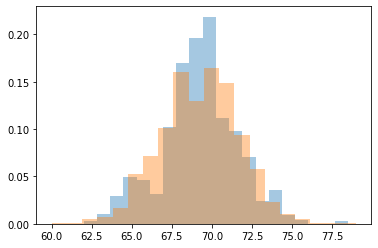

In [10]:
plt.hist(parents, density=True, alpha=0.4, bins=20)
plt.hist(df.NormOffspring, density=True, alpha=0.4, bins=20);

In [11]:
r = np.corrcoef(df.NormOffspring, df.NormParental)[0][1]
r

0.5108157463642389

In [12]:
df.NormOffspring.std() / parents.std()

1.0497840061896708

In [13]:
df.NormOffspring.mean() - parents.mean()

-0.004033575208950424

In [14]:
assert df.NormParental.mean() - parents.mean() == 0

### Stretch

The normed parental or mid-parental heights will have a smaller standard deviation than the parent generation - by multiplying the standard deviation by its ratio with the parent generation standard deviation - in order to set the normed parental standard deviation equal to the parental generation standard deviation. This is a linear transformation and therefore does not affect the correlation coefficient or any of the model results. 

In [57]:
df.NormParental.std() / parents.std()

0.7330380515082695

In [46]:
df['NormParentalStretch'] = df.NormParental.mean() + (df.NormParental - df.NormParental.mean()
                                              ) * parents.std() / df.NormParental.std()

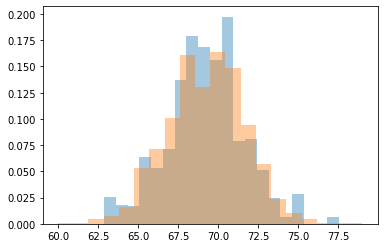

In [48]:
plt.hist(df.NormParentalStretch, density=True, alpha=0.4, bins=20)
plt.hist(df.NormOffspring, density=True, alpha=0.4, bins=20);

In [51]:
np.corrcoef(df.NormOffspring, df.NormParentalStretch)[0][1]

0.5108157463642387

### Z scores

In [15]:
df['NPZ'] = (df.NormParental - df.NormParental.mean()) / df.NormParental.std()

In [16]:
df['NOZ'] = (df.NormOffspring - df.NormOffspring.mean()) / df.NormOffspring.std()

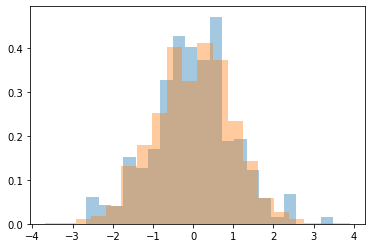

In [17]:
plt.hist(df.NPZ, density=True, alpha=0.4, bins=20)
plt.hist(df.NOZ, density=True, alpha=0.4, bins=20);

In [21]:
np.corrcoef(df.NOZ, df.NPZ)[0][1]

0.5108157463642388

In [52]:
df.NPZ.std()

0.9999999999999999

In [53]:
df.NOZ.std()

1.0

In [68]:
df['PredOffspring'] = df.NormOffspring.mean() + (df.NormOffspring.std() * r * (
                df.NormParental-df.NormParental.mean()) / df.NormParental.std())



In [69]:
a2 = df.NormOffspring.mean() + r * (df.NormParental-df.NormParental.mean())

In [70]:
(df.PredOffspring - a2).mean()

-4.7475015752345225e-17

#### Mean absolute error (for each family) is very low, as expected

In [60]:
(df.groupby('Family', sort=False).PredOffspring.mean() - df.groupby(
        'Family', sort=False).NormOffspring.mean()).mean()

-0.04480011742876357

In [63]:
df.NormOffspring.std()

2.5076225239399084

In [62]:
# Supposed to be zero
(df.PredOffspring - df.NormOffspring).mean()

4.161976380955598e-15

### Count each parent once

In [94]:
father_once = df.groupby('Family').Mother.mean().to_numpy()
mother_once = df.groupby('Family').Father.mean().to_numpy()

In [111]:
mother_once.mean()

69.3492385786802

In [112]:
df.Mother.mean()

64.08440979955456

In [95]:
k_mother_once = father_once.mean() - mother_once.mean()

In [97]:
parents_once = np.concatenate((mother_once + k_mother_once, father_once))

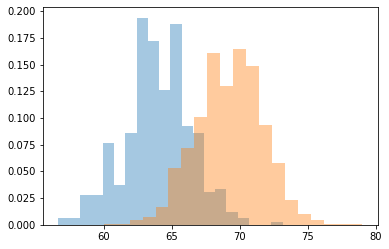

In [102]:
plt.hist(parents_once, density=True, alpha=0.4, bins=20)
plt.hist(df.NormOffspring, density=True, alpha=0.4, bins=20);